In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from bin.utils.models import LSTM, MLP
from bin.utils.data import get_data
from bin.utils.device import DEVICE
from sklearn.model_selection import train_test_split
from torch import Tensor

os.chdir('..')

from mascots.explainer.borf import BorfExplainer
from mascots.explainer.swapping import get_qunatiles

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from bin.utils.models import LSTM, MLP
from bin.utils.data import get_data
from bin.utils.device import DEVICE
from sklearn.model_selection import train_test_split
from torch import Tensor

os.chdir('..')

from mascots.explainer.borf import BorfExplainer
from mascots.explainer.swapping import get_qunatiles

In [2]:
X_train, y_train, X_test, y_test = get_data('FaultDetectionA')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=100, stratify=y_train, random_state=123)

In [3]:
model_path = 'lightning_logs/version_96/checkpoints/best_model-epoch=2-val_loss=0.8220-train_loss=0.7077.ckpt'
blackbox = LSTM.load_from_checkpoint(model_path).to(DEVICE)

for param in blackbox.parameters():
    param.requires_grad = False
    
blackbox.eval()

LSTM(
  (lstm): LSTM(5120, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=1024, out_features=3, bias=True)
  (softmax): Softmax(dim=None)
)

In [4]:
explainer = BorfExplainer(blackbox.forward_cls, blackbox.forward, borf_config='config/5120_borf_experimental_simple.json')
scores = explainer.build(np.array(X_train),
                            MLP(217, 3, 64, 5).to(DEVICE),
                            'shap',
                            attribution_args={'mode': 'normal'})

/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name

Training: |          | 0/? [00:00<?, ?it/s]

/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
`Trainer.fit` stopped: `max_epochs=10` reached.


(100, 217)


/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/numba/typed/typeddict.py:39: NumbaTypeSafetyWarning: unsafe cast from int64 to uint64. Precision may be lost.
  return d[key]
2025-02-07 12:57:39.713 | INFO     | borf.explainer.borf:_map_borf_features:225 - create inner representation


In [5]:
err = (explainer.borf_pipeline.predict(X_train) - blackbox(X_train).detach().cpu().numpy())
err.std()

/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


np.float32(0.46797386)

In [6]:
(explainer.attribution_method.attr_method(explainer.borf.transform(X_train).toarray()).values != 0).mean()

/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/home/dawid/miniconda3/envs/borf/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
PermutationExplainer explainer: 101it [00:11,  1.15it/s]                        


np.float64(0.9907834101382489)

In [7]:
y_pred = blackbox(X_train).detach().cpu().numpy()
loglik = (y_pred * np.log(y_pred)).sum(axis=1)
order = np.argsort(loglik)
list(zip(order, np.argmax(y_pred, axis=1)[order]))[:10]

[(np.int64(38), np.int64(1)),
 (np.int64(9), np.int64(2)),
 (np.int64(64), np.int64(0)),
 (np.int64(24), np.int64(0)),
 (np.int64(41), np.int64(1)),
 (np.int64(3), np.int64(2)),
 (np.int64(19), np.int64(1)),
 (np.int64(51), np.int64(0)),
 (np.int64(12), np.int64(0)),
 (np.int64(45), np.int64(2))]

In [49]:
IDX: int = 38
y_target = np.argsort(-blackbox(X_train[[IDX]]).detach().cpu().numpy())[0][1]

print(f'{blackbox.forward_cls_np(X_train[[IDX]])=}')
print(f'{y_target=}')
print(f'{blackbox(X_train[[IDX]])=}')
print()

counterfactual, meta = explainer.counterfactual(
    np.array(X_train[[IDX]]),
    target_cls=y_target,
    max_borf_changes=20,
    n_restarts=1, 
    select_top_k=1,
    # min_symbol_size=16,
    min_word_len_change=126,
    # max_word_len_change=64,
    C=1,
    )

blackbox.forward_cls_np(X_train[[IDX]])=array([1])
y_target=np.int64(2)
blackbox(X_train[[IDX]])=tensor([[4.9335e-05, 9.9494e-01, 5.0062e-03]], device='cuda:0')

tensor([[3.0510e-04, 9.2759e-01, 7.2105e-02]], device='cuda:0')
tensor([[0.0007, 0.6812, 0.3181]], device='cuda:0')
tensor([[0.0009, 0.4690, 0.5301]], device='cuda:0')


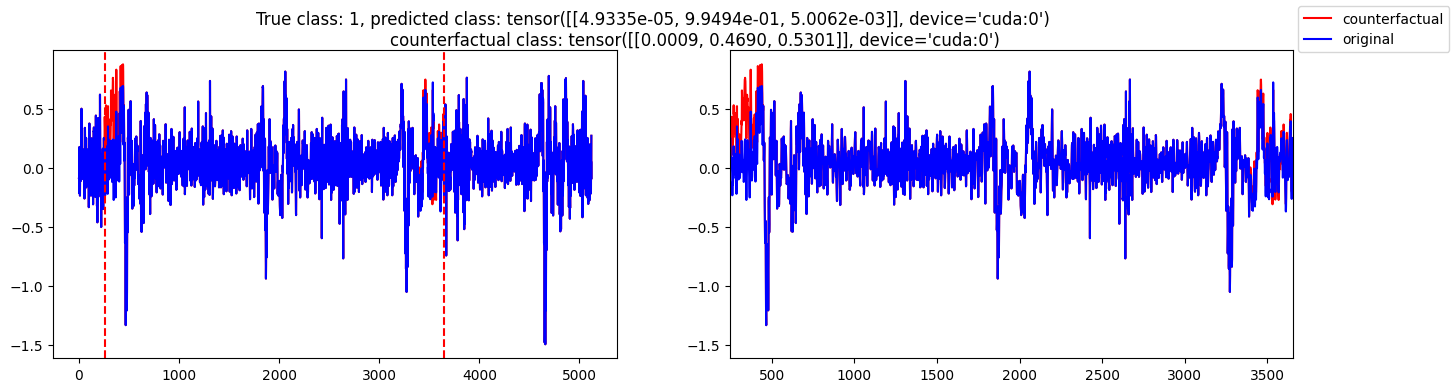

In [50]:
with torch.no_grad():
        
        fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
        
        coutnerfactual_idx = 0

        steps = np.arange(np.array(X_train).shape[2])

        # for i in range(len(counterfactual)):
        ax[0].plot(steps, counterfactual[coutnerfactual_idx][0,:], c='r', label='counterfactual')
        ax[0].plot(steps, X_train[IDX,0,:], c='b', label="original")
        
        ax[1].plot(steps, counterfactual[coutnerfactual_idx][0,:], c='r')
        ax[1].plot(steps, X_train[IDX,0,:], c='b')

        probs_org = blackbox(Tensor(X_train[[IDX],:,:]))

        probs_cnt = blackbox(Tensor(counterfactual[[coutnerfactual_idx],:,:]))

        fig.suptitle(f"""True class: {y_train[IDX]}, predicted class: {probs_org}
                counterfactual class: {probs_cnt}""")

        fig.legend()

        area = np.arange(X_train.shape[2])[X_train[IDX,0,:]-counterfactual[coutnerfactual_idx,0,:] != 0]
        ax[1].set_xlim(area.min() - 10, area.max() + 10)
        ax[0].axvline(area.min(), linestyle='--', c='r')
        ax[0].axvline(area.max(), linestyle='--', c='r')

In [51]:
cnt_steps = list(map(lambda x: x['new_obs'], meta[0].values()))
cnt_shapes = list(map(lambda x: x['added_shapes_candidates'][x['selected_swap'][0]].tolist(), meta[0].values()))
cnt_shapes_removed = list(map(lambda x: x['removed_shapes_candidates'][x['selected_swap'][0]].tolist(), meta[0].values()))
cnt_window_sizes = list(map(lambda x: x['windows_size'][0], meta[0].values()))

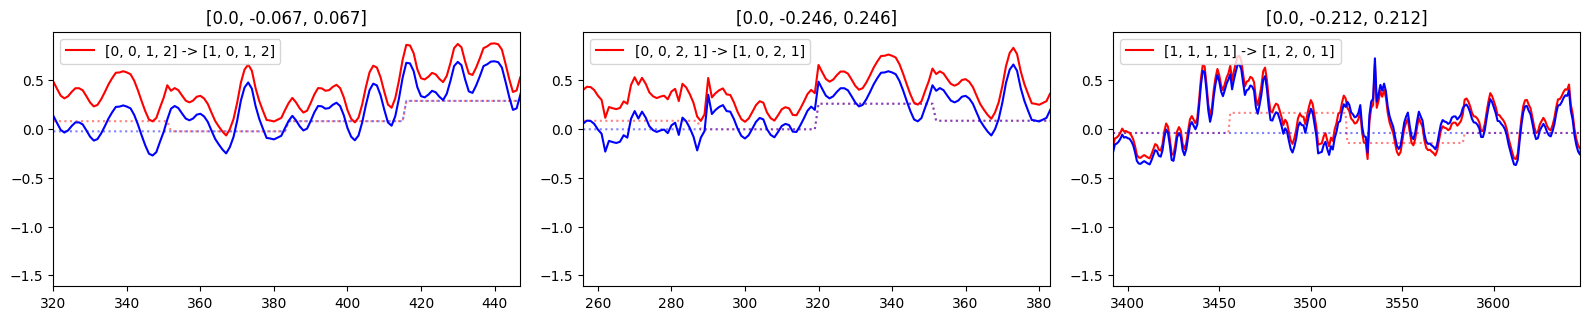

In [52]:
ncols = 3
nrows = (len(cnt_steps)+1) // ncols + 1

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(16, 3*nrows))
ax = ax.flatten()

for idx in range(len(cnt_steps)):
    new_cnt = cnt_steps[idx][0,0,:]
    probs_cnt = blackbox(Tensor(cnt_steps[idx][[0],:,:]))
    if idx == 0:
        old_cnt = X_train[IDX,0,:]
    else:
        old_cnt = cnt_steps[idx-1][0,0,:]
        
    area = np.arange(X_train.shape[2])[new_cnt-old_cnt != 0]
    
    m, std = old_cnt[area].mean(), old_cnt[area].std()
    qs = get_qunatiles(3, 2) * std + m
    
    new_qs = np.repeat(qs[cnt_shapes[idx]], repeats=cnt_window_sizes[idx] // np.array(cnt_shapes_removed[idx]).shape[0])
    ax[idx].plot(steps[area], new_qs, c='r', linestyle=':', alpha=0.5)
        
    old_qs = np.repeat(qs[cnt_shapes_removed[idx]], repeats=cnt_window_sizes[idx] // np.array(cnt_shapes_removed[idx]).shape[0])
    ax[idx].plot(steps[area], old_qs, c='b', linestyle=':', alpha=0.5)
        
    ax[idx].plot(steps, new_cnt, c='r', label=f'{cnt_shapes_removed[idx]} -> {cnt_shapes[idx]}')
    ax[idx].plot(steps, old_cnt, c='b')
    probs_org = blackbox(Tensor(old_cnt[torch.newaxis,torch.newaxis,:]))
        
    ax[idx].legend(loc='upper left')
    ax[idx].set_xlim(area.min(), area.max())
    
    change = (probs_cnt - probs_org).detach().cpu().numpy().tolist()[0]
    change_str = [float(f'{el:.3f}') for el in change]
    ax[idx].set_title(change_str)
    
    
for idx in range(len(cnt_steps), nrows*ncols):
    fig.delaxes(ax[idx])

plt.tight_layout()